In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2020"

maddat = madrigalWeb.madrigalWeb.MadrigalData('http://isr.sri.com/madrigal/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2016, 11, 23, 7,0)
et=datetime.datetime(2016, 11, 23, 15,0)

expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second, et.year, et.month, et.day, et.hour, et.minute, et.second)
for exp in expList:
    print(exp)

id: 30006628
realUrl: http://isr.sri.com/madrigal/cgi-bin/madExperiment.cgi?exp=2016/pfa/23nov16a&displayLevel=0&expTitle=Themis36+-+Auroral+and+convection+measurements
url: http://isr.sri.com/madrigal/cgi-bin/madtoc/2016/pfa/23nov16a
name: Themis36 - Auroral and convection measurements
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2016
startmonth: 11
startday: 23
starthour: 6
startmin: 0
startsec: 58
endyear: 2016
endmonth: 11
endday: 23
endhour: 17
endmin: 0
endsec: 0
isLocal: True
madrigalUrl: http://isr.sri.com/madrigal
PI: unknown
PIEmail: unknown
uttimestamp: None
access: None
Madrigal version: 2.6.2



In [5]:
fileList = maddat.getExperimentFiles(expList[0].id)
acfile=None
for file in fileList:
    if re.match('Alternating Code \(AC16-30\)',file.kindatdesc):
        acfile=file
        
filename=acfile.name
outfilename=acfile.name.split('/')[-1]
result = maddat.downloadFile(filename,outfilename, user_fullname, user_email, user_affiliation, 'hdf5')

In [6]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = 10**(dat['2D Parameters/nel'][:])
        outdct['dne'] = 10**(dat['2D Parameters/dnel'][:])
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [7]:
for i,d in enumerate(PFISR_data):
    print(d['bid'],d['azm'],d['elm'])

63149.0 -69.5 70.0
63197.0 -35.09 66.19
63239.0 -16.23 58.68
63281.0 -2.95 47.55
63317.0 110.5 70.0
63365.0 76.09 66.19
63401.0 57.23 58.68
63449.0 43.95 47.55
64016.0 14.04 90.0
64031.0 20.5 80.0
64046.0 20.5 70.0
64067.0 20.5 58.0
64157.0 -154.3 77.5
64163.0 15.0 38.0
64205.0 19.39 46.88
64232.0 10.34 49.87
64247.0 33.1 47.99
64475.0 2.41 61.35
64817.0 41.53 62.26
64973.0 -14.88 71.7
65057.0 58.52 72.43
65282.0 -69.91 80.96
65363.0 118.82 80.73


In [8]:
#find the up-B beam
bind=0
for i,d in enumerate(PFISR_data):
    if d['elm']==77.5:
        bind=i
bdat=PFISR_data[bind]

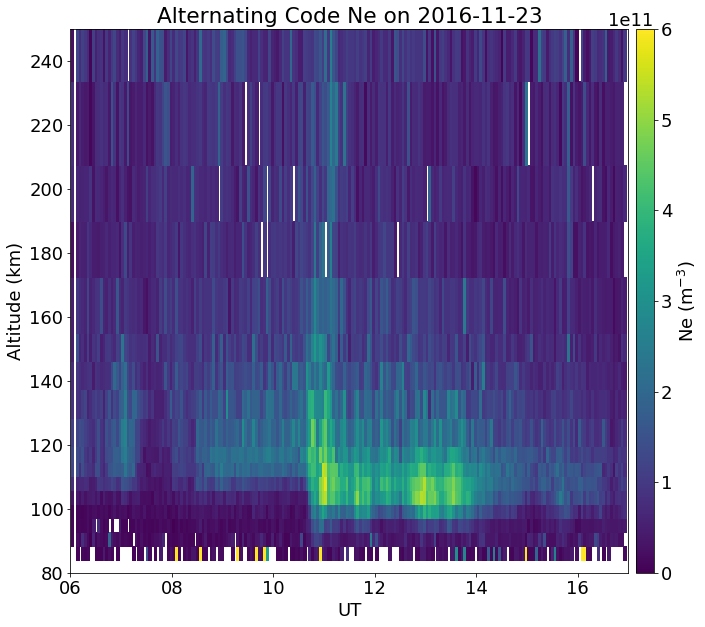

In [9]:
plt.rcParams['figure.figsize']=10,10
plt.rcParams['font.size']=18
fig,ax=plt.subplots(1,1)
clrs = ax.pcolormesh(mdates.date2num(bdat['time']),bdat['altitude'],bdat['ne'],vmin=0,vmax=6e11,shading='nearest')

ax.set_xlim([mdates.date2num(datetime.datetime(2016,11,23,6,0,0)),mdates.date2num(datetime.datetime(2016,11,23,17,0,0))])
ax.set_xticks(np.arange(mdates.date2num(datetime.datetime(2016,11,23,6,0,0)),mdates.date2num(datetime.datetime(2016,11,23,17,0,0)),2.0001/24.0))
ax.set_ylim([80,250])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_xlabel('UT')
ax.set_ylabel('Altitude (km)')
ax.set_title('Alternating Code Ne on 2016-11-23')

box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.set_label('Ne (m$^{-3}$)')

# Questions

1. What is producing the E-region electron density in this plot?

2. How do the density profiles differ before and after 11 UT?

3. Use https://www.gi.alaska.edu/monitors/magnetometer/archive to find the Poker Flat Magnetometer data from this same date and time. Does anything special happen in the magnetometer data that lines up with an event in the PFISR data?